In [1]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install pyreadr

     |████████████████████████████████| 261 kB 415 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
# %matplotlib inline
import math

from urllib.parse import urljoin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer

# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble importGradientBoostingRegressor, VotingRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, cross_val_predict, train_test_split

import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers,regularizers

import pyreadr

IS_COLAB = 'google.colab' in sys.modules

# palabras a buscar en columna descripción
TEXT_MINING_KEYWORDS = ['balcon', 'cochera', 'sum', 'parrilla', 'pileta']

# url repositorio
GITHUB_REPOSITORY_URL = 'https://github.com/arielfaur/prediccion-precio-propiedades-fmap-2020/raw/master/'
BASE_URL_DATA = GITHUB_REPOSITORY_URL if IS_COLAB else ''

def vectorize_descripcion(df: pd.DataFrame):
    
    # entrenamos el modelo para buscar las keywords
    vectorizer = CountVectorizer(binary=True, strip_accents='unicode')  
    vectorizer.fit(TEXT_MINING_KEYWORDS)

    # hot encoding de los resultados
    desc = vectorizer.transform(df['descripcion'])

    # crear dataframe con resultados
    df_desc = pd.DataFrame(data=desc.toarray(), columns=vectorizer.get_feature_names())
    return pd.concat([df.reset_index(drop=True), df_desc.reset_index(drop=True)], axis=1, sort=False)

def get_outliers(df: pd.DataFrame):
    return df[df_train['id'].isin(['7798', '31417', '10764', '12865', '22126', '49492'])]

def remove_outliers(df: pd.DataFrame):
    outliers = get_outliers(df)
    df.drop(outliers.index, inplace=True)

def preprocessing(df: pd.DataFrame, process_outliers = True):
    # nombres features en minuscula
    df.columns = map(str.lower, df.columns)

    df['barrio'] = df['barrio'].astype('category')
    df['cluster'] = df['cluster'].astype('category')
    df['id'] = df['id'].astype('int')
    
    # guardar los id
    ids = df['id']
    
    # eliminar outliers
    if process_outliers:
        remove_outliers(df)
    
    # text mining buscar keywords en descripcion
    df['descripcion'].fillna('', inplace=True)
    df = vectorize_descripcion(df)
    
    # eliminar columnas innecesarias del modelo
    df.drop([
        'banios',
        # 'barrio', 
        'subbarrio',
        'descripcion',
        'p_mt2', 
        'n_bancos',
        'n_barrios_p', 
        'n_bici', 
        'n_boliches', 
        'n_clinicas', 
        'n_comisarias',
        'n_embajadas', 
        'n_gasolina', 
        'n_gastronomica', 
        'n_homicidios',
        'n_hospitales', 
        'n_hurtos', 
        'n_hurtos_auto',
        'n_robo', 
        'n_robo_vehi',
        'n_subte_bocas', 
        'n_uni',
        'cluster',
        # 'terraza',
        'lujo',
        'sup_cubierta'
    ],axis=1, inplace=True, errors='raise')


    return ids, df.set_index('id')


def split_data(df: pd.DataFrame, test_size = 0.05):
    y = df[['precio']]
    X = df.drop(['precio'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=5)
    return X_train, X_test, y_train, y_test


## Preprocesamiento de los features: imputación, estandarización, one-hot encoding
def make_transformer_pipeline():
    numeric_transformer = make_pipeline( 
        SimpleImputer(missing_values = np.nan, strategy='mean'),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        #SimpleImputer(strategy='constant', fill_value='missing'),
        #SimpleImputer(strategy="most_frequent"),
        #KNNImputer(n_neighbors=3, weights="uniform"),     # KNNImputer tarda una eternidad...
        OneHotEncoder(handle_unknown='ignore')
    )

    return make_column_transformer(
        (numeric_transformer, make_column_selector(dtype_include=['int64', 'float64'])),
        (categorical_transformer, make_column_selector(dtype_include=['category']))
    )    

def baseline_ada_model_pipeline():
    transformer = make_transformer_pipeline()
    ada = AdaBoostRegressor(random_state = 5)
    
    return make_pipeline(transformer, TransformedTargetRegressor(ada, func=np.log, inverse_func=np.exp))    

def create_train_ada_model():
    transformer = make_transformer_pipeline()

    model = Pipeline([
        ('preprocessing', transformer),
        ('model', TransformedTargetRegressor(AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), loss='square', random_state=5), func=np.log, inverse_func=np.exp))
    ])
    return model

# # Crear modelo red neuronal Keras
# def build_1layer_keras_model(input_dim, n_neurons = 8):    
#     model = keras.Sequential()
#     model.add(layers.Dense(n_neurons, activation='relu', input_dim=input_dim))
#     model.add(layers.Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

#     return model

# Crear modelo red neuronal Keras
def build_dense_keras_model(input_dim, n_neurons = [8, 8], lr = 0.001, dropout = False):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model = keras.Sequential()
    for idx, n in enumerate(n_neurons):
        if idx==0:
            model.add(layers.Dense(n, activation='relu', kernel_initializer='random_normal', input_dim=input_dim))
            if dropout: model.add(layers.Dropout(.1))
        else:
            model.add(layers.Dense(n, activation='relu', kernel_initializer='random_normal'))
            if dropout: model.add(layers.Dropout(.1))
                
    model.add(layers.Dense(1, kernel_initializer='random_normal'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

# # Pipeline preprocesamiento para red neuronal
# def create_keras_pipeline():
#     EPOCHS = 300
#     BATCH_SIZE = 32

#     transformer = make_transformer_pipeline()
#     pipeline = Pipeline([
#         ('preprocessing', transformer),
#         ('model', TransformedTargetRegressor(KerasRegressor(build_fn=build_1layer_keras_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1), 
#         transformer=QuantileTransformer(output_distribution='normal', random_state=5)
#         ))
#     ])
#     return pipeline

# Graficar predicciones
def plot_test_predictions(y_test, y_pred):
    # graficar predicciones contra datos actuales
    fig, ax = plt.subplots(figsize = (18,10))
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Precio test')
    ax.set_ylabel('Precio predicción')
    plt.show()

def read_rds(filename):
    result = pyreadr.read_r(filename)
    return result[None]

# Cargar datos entrenamiento

In [5]:
df_train = read_rds(urljoin(BASE_URL_DATA,'data_train_def.rds'))

In [ ]:
df_train.info()

In [ ]:
df_train.describe()

## Preprocesamiento

In [6]:
ids, df_train = preprocessing(df_train)
df_train.head()

,lat,lon,precio,barrio,a_estrenar,dormitorios,sup_total,habitaciones,terraza,balcon,cochera,parrilla,pileta,sum
id,,,,,,,,,,,,,,
4,-34.600886,-58.431204,145000.0,villa crespo,0.0,2.0,57.0,3.0,0.0,0,0,0,0,0
6,-34.572144,-58.480173,237000.0,villa urquiza,0.0,2.0,60.0,3.0,1.0,1,0,0,0,0
8,-34.563209,-58.468897,130000.0,coghlan,0.0,1.0,49.0,2.0,1.0,1,0,0,0,0
11,-34.555333,-58.466432,230000.0,nuñez,0.0,2.0,55.0,3.0,1.0,1,1,0,0,0
12,-34.629200,-58.452566,144900.0,flores,1.0,1.0,48.0,2.0,1.0,1,0,1,0,0


In [7]:
test_size = round(2500 / len(df_train), 2)
test_size

0.12

In [124]:
X_train, X_test, y_train, y_test = split_data(df_train, test_size=test_size)

In [125]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17921, 13), (2444, 13), (17921, 1), (2444, 1))

In [ ]:
sns.pairplot(df_train, vars=['sup_total','habitaciones','precio'], hue='cluster', height=3)

# Pipeline preprocesamiento

In [126]:
pipe = make_transformer_pipeline()
X_train = pipe.fit_transform(X_train).toarray()
y_train = y_train.values

In [127]:
X_train, y_train

(array([[ 0.84540209,  0.95209473, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.49640854,  0.63657231, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [-1.45550193, -0.73194261, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.13721597,  0.19559168, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.66476808,  0.33972116, -0.39275613, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.53212571, -1.03902861, -0.39275613, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[210000.],
        [205500.],
        [111000.],
        ...,
        [330000.],
        [196531.],
        [120000.]]))

(array([1.061e+03, 8.709e+03, 5.972e+03, 1.634e+03, 4.190e+02, 9.700e+01,
        2.100e+01, 4.000e+00, 3.000e+00, 1.000e+00]),
 array([ 20000.,  75798., 131596., 187394., 243192., 298990., 354788.,
        410586., 466384., 522182., 577980.]),
 <a list of 10 Patch objects>)

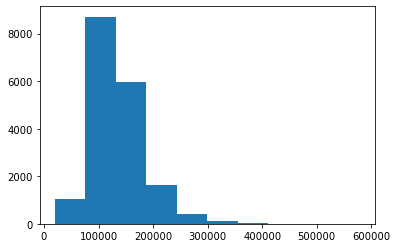

In [12]:
plt.hist(y_train)

# Modelo red densa Keras

In [128]:
EPOCHS = 2000
BATCH_SIZE = 32
STEPS_PER_EPOCH = X_train.shape[0]//BATCH_SIZE

initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate,
  decay_steps=STEPS_PER_EPOCH*50,
  decay_rate=1,
  staircase=False)


# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=15000,
#     decay_rate=0.95,
#     staircase=False)

# tfa.optimizers.AdamW(learning_rate=0.01, weight_decay=1e-4)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

initializer = tf.keras.initializers.he_uniform()    


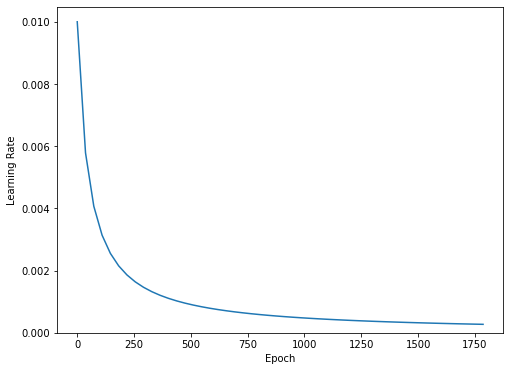

In [129]:
step = np.linspace(0,1000000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [130]:
model = keras.Sequential()
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.001), input_dim=X_train.shape[1]))
# model.add(layers.Dropout(rate=.2))
model.add(layers.Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# model.add(layers.Dropout(rate=.2))
model.add(layers.Dense(16, activation='relu', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 256)               14592     
_________________________________________________________________
dense_73 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_74 (Dense)             (None, 16)                4112      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 17        
Total params: 84,513
Trainable params: 84,513
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Callbacks #

# Parar entrenamiento cuando no mejora MSE
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

# Guardar modelo entrenado
# checkpoint = keras.callbacks.ModelCheckpoint('modelo_prediccion_propiedades.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

# Reducir learning rate cuando no mejora MSE
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.0001)


history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_split = 0.05, 
                    callbacks=[
#                         checkpoint, 
                        early_stop, 
#                         reduce_lr 
                        tfdocs.modeling.EpochDots()
                    ],
                    verbose=1)

Epoch 1/2000
548/560 [============================>.] - ETA: 0s - loss: 3186339328.0000 - root_mean_squared_error: 56447.6680
Epoch: 0, loss:3133675776.0000,  root_mean_squared_error:55979.2461,  val_loss:1095931776.0000,  val_root_mean_squared_error:33104.8594,  
560/560 [==============================] - 1s 2ms/step - loss: 3133675776.0000 - root_mean_squared_error: 55979.2461 - val_loss: 1095931776.0000 - val_root_mean_squared_error: 33104.8594
Epoch 2/2000
560/560 [==============================] - 1s 2ms/step - loss: 894616256.0000 - root_mean_squared_error: 29910.1328 - val_loss: 1040441920.0000 - val_root_mean_squared_error: 32255.8828
Epoch 3/2000
560/560 [==============================] - 1s 2ms/step - loss: 853031104.0000 - root_mean_squared_error: 29206.6934 - val_loss: 1035018944.0000 - val_root_mean_squared_error: 32171.7090
Epoch 4/2000
560/560 [==============================] - 1s 2ms/step - loss: 830781120.0000 - root_mean_squared_error: 28823.2734 - val_loss: 100818201

Epoch 41/2000
560/560 [==============================] - 1s 2ms/step - loss: 700454784.0000 - root_mean_squared_error: 26466.1016 - val_loss: 935674368.0000 - val_root_mean_squared_error: 30588.7910
Epoch 42/2000
560/560 [==============================] - 1s 2ms/step - loss: 715483904.0000 - root_mean_squared_error: 26748.5293 - val_loss: 946832512.0000 - val_root_mean_squared_error: 30770.6426
Epoch 43/2000
560/560 [==============================] - 1s 2ms/step - loss: 689795200.0000 - root_mean_squared_error: 26263.9473 - val_loss: 917391104.0000 - val_root_mean_squared_error: 30288.4629
Epoch 44/2000
560/560 [==============================] - 1s 2ms/step - loss: 700275712.0000 - root_mean_squared_error: 26462.7188 - val_loss: 930999168.0000 - val_root_mean_squared_error: 30512.2793
Epoch 45/2000
560/560 [==============================] - 1s 2ms/step - loss: 681977152.0000 - root_mean_squared_error: 26114.6914 - val_loss: 914866624.0000 - val_root_mean_squared_error: 30246.7617
Epoch

560/560 [==============================] - 1s 2ms/step - loss: 630757056.0000 - root_mean_squared_error: 25114.8730 - val_loss: 902354048.0000 - val_root_mean_squared_error: 30039.2012
Epoch 83/2000
560/560 [==============================] - 1s 2ms/step - loss: 619666624.0000 - root_mean_squared_error: 24893.0996 - val_loss: 907887232.0000 - val_root_mean_squared_error: 30131.1641
Epoch 84/2000
560/560 [==============================] - 1s 2ms/step - loss: 624590592.0000 - root_mean_squared_error: 24991.8047 - val_loss: 902636800.0000 - val_root_mean_squared_error: 30043.9121
Epoch 85/2000
560/560 [==============================] - 1s 2ms/step - loss: 600185984.0000 - root_mean_squared_error: 24498.6914 - val_loss: 886544640.0000 - val_root_mean_squared_error: 29774.8965
Epoch 86/2000
560/560 [==============================] - 1s 2ms/step - loss: 630249600.0000 - root_mean_squared_error: 25104.7695 - val_loss: 903257856.0000 - val_root_mean_squared_error: 30054.2461
Epoch 87/2000
560/5

Epoch 122/2000
560/560 [==============================] - 1s 2ms/step - loss: 562187648.0000 - root_mean_squared_error: 23710.4922 - val_loss: 911525312.0000 - val_root_mean_squared_error: 30191.4707
Epoch 123/2000
560/560 [==============================] - 1s 2ms/step - loss: 582255104.0000 - root_mean_squared_error: 24129.9590 - val_loss: 908539648.0000 - val_root_mean_squared_error: 30141.9883
Epoch 124/2000
560/560 [==============================] - 1s 2ms/step - loss: 554643648.0000 - root_mean_squared_error: 23550.8711 - val_loss: 901897280.0000 - val_root_mean_squared_error: 30031.6016
Epoch 125/2000
560/560 [==============================] - 1s 2ms/step - loss: 556583936.0000 - root_mean_squared_error: 23592.0254 - val_loss: 916556416.0000 - val_root_mean_squared_error: 30274.6777
Epoch 126/2000
560/560 [==============================] - 1s 2ms/step - loss: 575101824.0000 - root_mean_squared_error: 23981.2754 - val_loss: 892525376.0000 - val_root_mean_squared_error: 29875.1582


Epoch 163/2000
560/560 [==============================] - 1s 2ms/step - loss: 534045728.0000 - root_mean_squared_error: 23109.4219 - val_loss: 893273664.0000 - val_root_mean_squared_error: 29887.6797
Epoch 164/2000
560/560 [==============================] - 1s 2ms/step - loss: 551432576.0000 - root_mean_squared_error: 23482.5957 - val_loss: 898964736.0000 - val_root_mean_squared_error: 29982.7344
Epoch 165/2000
560/560 [==============================] - 1s 2ms/step - loss: 507908800.0000 - root_mean_squared_error: 22536.8242 - val_loss: 905482944.0000 - val_root_mean_squared_error: 30091.2402
Epoch 166/2000
560/560 [==============================] - 1s 2ms/step - loss: 545692160.0000 - root_mean_squared_error: 23360.0508 - val_loss: 896366848.0000 - val_root_mean_squared_error: 29939.3828
Epoch 167/2000
560/560 [==============================] - 1s 2ms/step - loss: 531109600.0000 - root_mean_squared_error: 23045.8066 - val_loss: 892794432.0000 - val_root_mean_squared_error: 29879.6621


Epoch 203/2000
560/560 [==============================] - 1s 2ms/step - loss: 506888256.0000 - root_mean_squared_error: 22514.1719 - val_loss: 908002816.0000 - val_root_mean_squared_error: 30133.0801
Epoch 204/2000
560/560 [==============================] - 1s 2ms/step - loss: 507221376.0000 - root_mean_squared_error: 22521.5684 - val_loss: 894825536.0000 - val_root_mean_squared_error: 29913.6309
Epoch 205/2000
560/560 [==============================] - 1s 2ms/step - loss: 512999552.0000 - root_mean_squared_error: 22649.4844 - val_loss: 900602944.0000 - val_root_mean_squared_error: 30010.0410
Epoch 206/2000
560/560 [==============================] - 1s 2ms/step - loss: 513056896.0000 - root_mean_squared_error: 22650.7520 - val_loss: 893549952.0000 - val_root_mean_squared_error: 29892.3008
Epoch 207/2000
560/560 [==============================] - 1s 2ms/step - loss: 497634272.0000 - root_mean_squared_error: 22307.7109 - val_loss: 895126272.0000 - val_root_mean_squared_error: 29918.6543


Epoch 244/2000
560/560 [==============================] - 1s 2ms/step - loss: 483427488.0000 - root_mean_squared_error: 21986.9746 - val_loss: 900067968.0000 - val_root_mean_squared_error: 30001.1250
Epoch 245/2000
560/560 [==============================] - 1s 2ms/step - loss: 490641760.0000 - root_mean_squared_error: 22150.4297 - val_loss: 893474112.0000 - val_root_mean_squared_error: 29891.0312
Epoch 246/2000
560/560 [==============================] - 1s 2ms/step - loss: 490250240.0000 - root_mean_squared_error: 22141.5879 - val_loss: 897960192.0000 - val_root_mean_squared_error: 29965.9805
Epoch 247/2000
560/560 [==============================] - 1s 2ms/step - loss: 487037088.0000 - root_mean_squared_error: 22068.9082 - val_loss: 900069760.0000 - val_root_mean_squared_error: 30001.1562
Epoch 248/2000
560/560 [==============================] - 1s 2ms/step - loss: 488430560.0000 - root_mean_squared_error: 22100.4570 - val_loss: 903448768.0000 - val_root_mean_squared_error: 30057.4199


Epoch 285/2000
560/560 [==============================] - 1s 2ms/step - loss: 478360544.0000 - root_mean_squared_error: 21871.4512 - val_loss: 896092288.0000 - val_root_mean_squared_error: 29934.7949
Epoch 286/2000
560/560 [==============================] - 1s 2ms/step - loss: 473688704.0000 - root_mean_squared_error: 21764.3789 - val_loss: 892626688.0000 - val_root_mean_squared_error: 29876.8535
Epoch 287/2000
560/560 [==============================] - 1s 2ms/step - loss: 485561792.0000 - root_mean_squared_error: 22035.4551 - val_loss: 899196864.0000 - val_root_mean_squared_error: 29986.6055
Epoch 288/2000
560/560 [==============================] - 1s 2ms/step - loss: 463515296.0000 - root_mean_squared_error: 21529.3965 - val_loss: 898043008.0000 - val_root_mean_squared_error: 29967.3574
Epoch 289/2000
560/560 [==============================] - 1s 2ms/step - loss: 479005632.0000 - root_mean_squared_error: 21886.1875 - val_loss: 898617472.0000 - val_root_mean_squared_error: 29976.9395


Epoch 325/2000
560/560 [==============================] - 1s 2ms/step - loss: 460685408.0000 - root_mean_squared_error: 21463.5742 - val_loss: 907797888.0000 - val_root_mean_squared_error: 30129.6797
Epoch 326/2000
560/560 [==============================] - 1s 2ms/step - loss: 472264480.0000 - root_mean_squared_error: 21731.6387 - val_loss: 908176384.0000 - val_root_mean_squared_error: 30135.9590
Epoch 327/2000
560/560 [==============================] - 1s 2ms/step - loss: 458456352.0000 - root_mean_squared_error: 21411.5840 - val_loss: 898510400.0000 - val_root_mean_squared_error: 29975.1582
Epoch 328/2000
560/560 [==============================] - 1s 2ms/step - loss: 460321760.0000 - root_mean_squared_error: 21455.0996 - val_loss: 902591680.0000 - val_root_mean_squared_error: 30043.1602
Epoch 329/2000
560/560 [==============================] - 1s 2ms/step - loss: 471098208.0000 - root_mean_squared_error: 21704.7891 - val_loss: 903021952.0000 - val_root_mean_squared_error: 30050.3164


Epoch 366/2000
560/560 [==============================] - 1s 2ms/step - loss: 447949248.0000 - root_mean_squared_error: 21164.8008 - val_loss: 895291008.0000 - val_root_mean_squared_error: 29921.4102
Epoch 367/2000
560/560 [==============================] - 1s 2ms/step - loss: 460087552.0000 - root_mean_squared_error: 21449.6406 - val_loss: 901544256.0000 - val_root_mean_squared_error: 30025.7227
Epoch 368/2000
560/560 [==============================] - 1s 2ms/step - loss: 462151232.0000 - root_mean_squared_error: 21497.6953 - val_loss: 893750208.0000 - val_root_mean_squared_error: 29895.6465
Epoch 369/2000
560/560 [==============================] - 1s 2ms/step - loss: 450053280.0000 - root_mean_squared_error: 21214.4512 - val_loss: 903029888.0000 - val_root_mean_squared_error: 30050.4492
Epoch 370/2000
560/560 [==============================] - 1s 2ms/step - loss: 451998592.0000 - root_mean_squared_error: 21260.2500 - val_loss: 902550784.0000 - val_root_mean_squared_error: 30042.4766


Epoch 406/2000
560/560 [==============================] - 1s 2ms/step - loss: 436747424.0000 - root_mean_squared_error: 20898.4961 - val_loss: 903292672.0000 - val_root_mean_squared_error: 30054.8242
Epoch 407/2000
560/560 [==============================] - 1s 2ms/step - loss: 449173376.0000 - root_mean_squared_error: 21193.6992 - val_loss: 911920960.0000 - val_root_mean_squared_error: 30198.0215
Epoch 408/2000
560/560 [==============================] - 1s 2ms/step - loss: 445852160.0000 - root_mean_squared_error: 21115.1992 - val_loss: 896234816.0000 - val_root_mean_squared_error: 29937.1738
Epoch 409/2000
560/560 [==============================] - 1s 2ms/step - loss: 452390752.0000 - root_mean_squared_error: 21269.4668 - val_loss: 917208704.0000 - val_root_mean_squared_error: 30285.4492
Epoch 410/2000
560/560 [==============================] - 1s 2ms/step - loss: 440174336.0000 - root_mean_squared_error: 20980.3203 - val_loss: 889578752.0000 - val_root_mean_squared_error: 29825.7969


Epoch 447/2000
560/560 [==============================] - 1s 2ms/step - loss: 439696736.0000 - root_mean_squared_error: 20968.9375 - val_loss: 900485760.0000 - val_root_mean_squared_error: 30008.0879
Epoch 448/2000
560/560 [==============================] - 1s 2ms/step - loss: 454455424.0000 - root_mean_squared_error: 21317.9531 - val_loss: 907165696.0000 - val_root_mean_squared_error: 30119.1855
Epoch 449/2000
560/560 [==============================] - 1s 2ms/step - loss: 422378464.0000 - root_mean_squared_error: 20551.8359 - val_loss: 900546880.0000 - val_root_mean_squared_error: 30009.1094
Epoch 450/2000
560/560 [==============================] - 1s 2ms/step - loss: 439392128.0000 - root_mean_squared_error: 20961.6719 - val_loss: 914385280.0000 - val_root_mean_squared_error: 30238.8008
Epoch 451/2000
560/560 [==============================] - 1s 2ms/step - loss: 440220480.0000 - root_mean_squared_error: 20981.4238 - val_loss: 894402880.0000 - val_root_mean_squared_error: 29906.5625


Epoch 488/2000
560/560 [==============================] - 1s 2ms/step - loss: 434787808.0000 - root_mean_squared_error: 20851.5566 - val_loss: 906233856.0000 - val_root_mean_squared_error: 30103.7129
Epoch 489/2000
560/560 [==============================] - 1s 2ms/step - loss: 439737696.0000 - root_mean_squared_error: 20969.9141 - val_loss: 908276480.0000 - val_root_mean_squared_error: 30137.6191
Epoch 490/2000
560/560 [==============================] - 1s 2ms/step - loss: 428053152.0000 - root_mean_squared_error: 20689.4336 - val_loss: 899562048.0000 - val_root_mean_squared_error: 29992.6934
Epoch 491/2000
560/560 [==============================] - 1s 2ms/step - loss: 429171008.0000 - root_mean_squared_error: 20716.4316 - val_loss: 909916608.0000 - val_root_mean_squared_error: 30164.8184
Epoch 492/2000
560/560 [==============================] - 1s 2ms/step - loss: 434635904.0000 - root_mean_squared_error: 20847.9160 - val_loss: 896636544.0000 - val_root_mean_squared_error: 29943.8828


# Graficar métricas entrenamiento

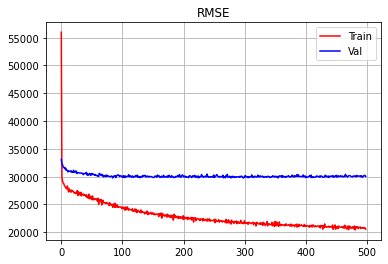

In [108]:
train_rmse = history.history['root_mean_squared_error']

val_rmse = history.history['val_root_mean_squared_error']


plt.plot(np.linspace(0, len(train_rmse),  len(train_rmse)), train_rmse,
             color='red', label='Train')

plt.plot(np.linspace(0, len(val_rmse), len(val_rmse)), val_rmse,
         color='blue', label='Val')

plt.title('RMSE')
plt.legend()
plt.grid(True)
plt.show()

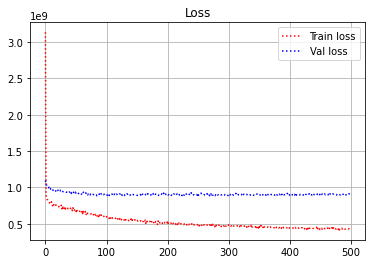

In [109]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.linspace(0, len(train_loss),  len(train_loss)), train_loss, 'r:',
             color='red', label='Train loss')
plt.plot(np.linspace(0, len(val_loss),  len(val_loss)), val_loss, 'b:',
             color='blue', label='Val loss')

plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

(array([174., 894., 857., 323., 140.,  35.,  12.,   5.,   2.,   2.]),
 array([ 35700. ,  78649.2, 121598.4, 164547.6, 207496.8, 250446. ,
        293395.2, 336344.4, 379293.6, 422242.8, 465192. ]),
 <a list of 10 Patch objects>)

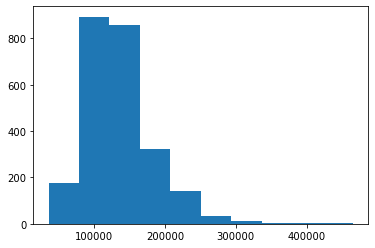

In [122]:
X_test = pipe.transform(X_test).toarray()
y_test = y_test.values
plt.hist(y_test)

In [123]:
loss, rmse = model.evaluate(X_test, y_test, verbose=2)
print("Testing set RMSE: {:5.2f}".format(rmse))

77/77 - 0s - loss: 20426993664.0000 - root_mean_squared_error: 142923.0312
Testing set RMSE: 142923.03


In [74]:
y_pred = model.predict(X_test).flatten()
y_pred

array([101227.74 , 152346.42 , 136065.11 , ..., 125091.445, 107057.63 ,
       123447.98 ], dtype=float32)

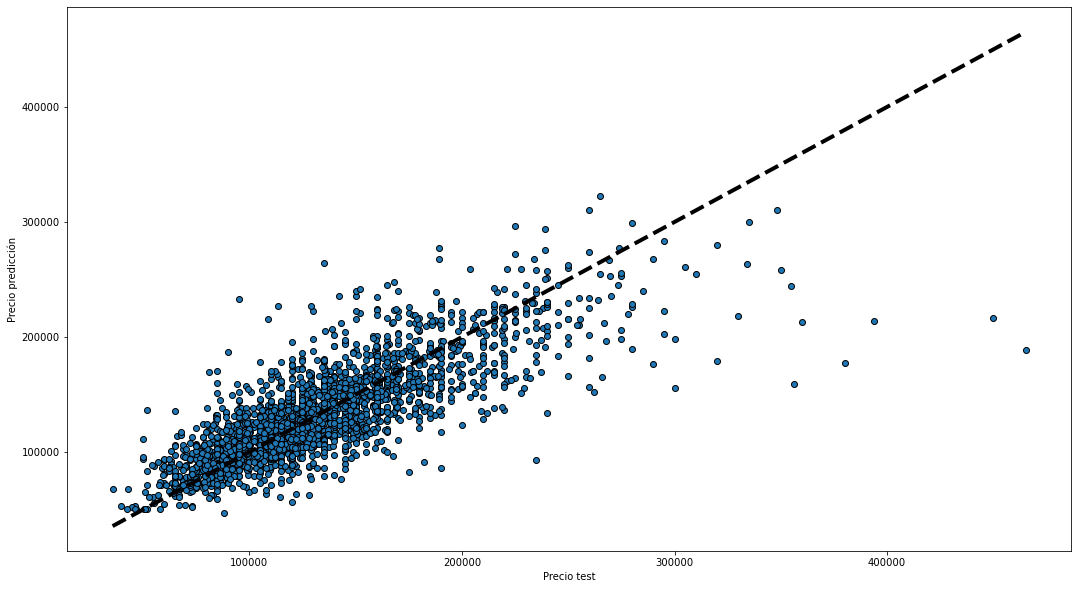

In [75]:
plot_test_predictions(y_test, y_pred)

# Preprocesamiento set de test

In [ ]:
df_test = read_rds(urljoin(BASE_URL_DATA,'data_test_def.rds'))
df_test.head()

In [ ]:
df_test.info()

In [ ]:
ids, df_test = preprocessing(df_test, process_outliers=False)

In [ ]:
df_test.head()

In [ ]:
df_test.drop(['precio'], axis=1, inplace=True)
df_test.head()

# Predicción con red neuronal

In [ ]:
X = pipe.transform(df_test)
X.shape

In [ ]:
y_pred = model.predict(X).flatten()
data = pd.DataFrame(data={'id' : ids.values, 'precio': np.round(y_pred).astype(int) })
data

In [ ]:
data.to_csv('propiedades_prediccion.csv', index=False)